In [ ]:
#default_exp SSD

In [ ]:
#export
from nbdev.showdoc import show_doc
from ModernArchitecturesFromPyTorch.nb_XResNet import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from fastai.vision.data import open_image

# Single Shot Detector
> Buiding an architecture to detect class and position of multiple entities in a single image. Based off of convolutional YOLO3 architecture. Paper:

## Dataset Preparation

In [ ]:
pascal_root = Path('PascalData')

In [ ]:
j = json.load((pascal_root/'PASCAL_VOC'/'pascal_train2007.json').open())
j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [ ]:
#hide
im, ann, cat = ['images', 'annotations', 'categories']
j[im][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [ ]:
#hide
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'
cats = {o[ID]:o['name'] for o in j[cat]}
trn_fns = {o[ID]:o[FILE_NAME] for o in j[im]}
trn_ids = [o[ID] for o in j[im]]

In [ ]:
#hide
jpgs = pascal_root/'VOCdevkit/VOC2007/JPEGImages'

In [ ]:
#export
def hw_bb(bb): 
    "Convert height width to bounding box coords"
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
 
def bb_hw(a): 
    "Convert bounding box coords to height width"
    return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [ ]:
#hide
trn_anno = collections.defaultdict(lambda:[])
for o in j[ann]:
    
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [ ]:
#hide
im0_d = j[im][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

In [ ]:
#hide
im = open_image(jpgs/im0_d[FILE_NAME])
im_a = trn_anno[im0_d[ID]]; im_a
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [ ]:
#export
def show_img(im, figsize=None, ax=None):
    "Show the given image"
    im = image2np(im.data)
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [ ]:
#export
def draw_outline(o, lw):
    "Draw the outline around a bounding box"
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [ ]:
#export
def draw_rect(ax, b):
    "Add a square capturing a given bounding box"
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [ ]:
#export
def draw_text(ax, xy, txt, sz=14):
    "Draw the class type aboce the bounding box of font size `sz`"
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

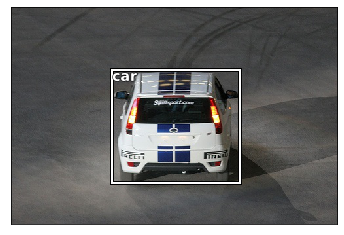

In [ ]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [ ]:
#export
def draw_im(im, ann):
    "Draw an image along with it's bounding box and class"
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [ ]:
#export
def draw_idx(i):
    "Open and draw a given image with id `i`"
    im_a = trn_anno[i]
    im = open_image(jpgs/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

torch.Size([3, 333, 500])


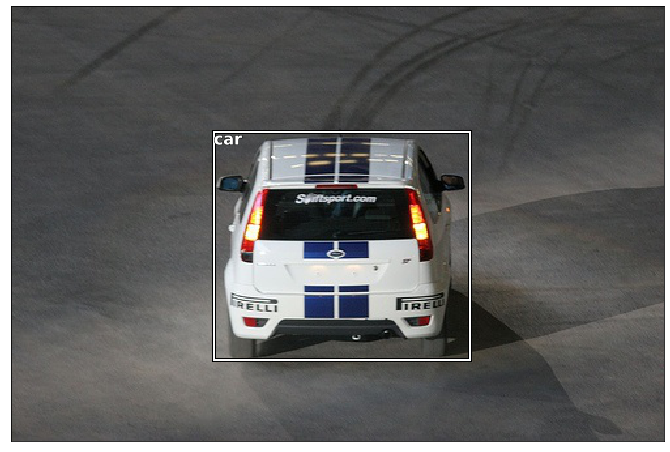

In [ ]:
draw_idx(12)

## Architecture

In [ ]:
#export
def get_res_body(size, n_in, c_out=10):
    "Return the body of a resnet with given `size` and `n_in` input channels"
    return getResnet(size, n_in, c_out).resnet[:-3]

In [ ]:
res_body = get_res_body(34, 3)

In [ ]:
res_body(torch.randn(1,3, 224, 224)).shape

torch.Size([1, 512, 7, 7])

We now have to take the output of the ResNet body and turn it into k outputs of size (4 + 4*c) where k is the number of anchor boxes, 4 outputs for bounding box coordinates and 4*c activations representing the predicted class

In [ ]:
#export
class StandardConv(nn.Module):
    "Standard convolutional layer to downsample the ResNet output"
    def __init__(self, n_in, n_out, ks=3, stride=2, drop=0.1, **kwargs):
        super().__init__()
        layers = [ConvBatchLayer(n_in, n_out, kernel_size=ks, **kwargs)]
        if drop > 0: layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, xb): return self.layers(xb)

In [ ]:
#export
class PredictionConv(nn.Module):
    "Convolutional layer to split activations into predicted bbox coordinates and classes"
    def __init__(self, k, n_in, n_clas):
        super().__init__()
        self.k = k
        self.class_conv = AutoConv(n_in, n_clas+1, kernel_size=3)
        self.bbox_conv = AutoConv(n_in, 4, kernel_size=3)
    
    def flatten_conv(self, xb, k):
        bs,n_c,gx,gy = xb.size()
        xb = xb.permute(0,2,3,1).contiguous
        xb = xb.view(bs, -1, n_c//k)
        return xb
    
    def forward(self, xb):
        return [self.flatten_conv(self.class_conv(xb), self.k),
                self.flatten_conv(self.bbox_conv(xb), self.k)]


In [ ]:
#export
class SSDHead(nn.Module):
    "Convolutional layers to split resnet body activations into predictions of various sizes. Each representing different regions of the image"
    def __init__(self, k, n_clas, drop=0.1):
        super().__init__()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(drop)
        self.initial_layer = StandardConv(512, 256, stride=1)
        self.conv_to_4 = StandardConv(256, 256)
        self.conv_to_2 = StandardConv(256, 256)
        self.conv_to_1 = StandardConv(256, 256)

        self.out_conv_4 = PredictionConv(k, 256, n_clas)
        self.out_conv_2 = PredictionConv(k, 256, n_clas)
        self.out_conv_1 = PredictionConv(k, 256, n_clas)
    
    def forward(self, xb):
        xb = self.initial_layer(xb)

        xb_4 = self.conv_to_4(xb)
        xb_4_clas, xb_4_bbox = self.out_conv_4(xb_4)

        xb_2 = self.conv_to_4(xb_4)
        xb_2_clas, xb_2_bbox = self.out_conv_4(xb_2)

        xb_1 = self.conv_to_4(xb_2)
        xb_1_clas, xb_1_bbox = self.out_conv_4(xb_1)

        return [torch.cat([xb_4_clas, xb_2_clas, xb_1_clas], dim=1),
                torch.cat([xb_4_bbox, xb_2_bbox, xb_1_bbox], dim=1)]

In [ ]:
#export
class GenericModel(nn.Module):
    "Wrapper to combine a head and body into a single model"
    def __init__(self, body, head):
        super().__init__()
        self.body = body
        self.head = head
    
    def forward(self, xb): return self.head(self.body(xb))

In [ ]:
ssd_head = SSDHead(9, 10)

In [ ]:
ssd = GenericModel(res_body, ssd_head)

In [ ]:
ssd

GenericModel(
  (body): Sequential(
    (0): ConvBatchLayer(
      (conv): AutoConv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Identity()
    )
    (1): ConvBatchLayer(
      (conv): AutoConv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Identity()
    )
    (2): ConvBatchLayer(
      (conv): AutoConv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Identity()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BaseRes(
        (blocks): Sequential(
      

In [ ]:
!python notebook2script.py SingleShotDetector.ipynb

Converted SingleShotDetector.ipynb to ModernArchitecturesFromPyTorch/nb_SingleShotDetector.py
